In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Project Overview

**This capstone project was developed as part of the 5-day Gen AI Intensive Course with Google (Monday, March 31 – Friday, April 4, 2025). The project aims to build an innovative AI-driven dental assistant.**

This project leverages Google Gen AI to generate dental-specific content and analyze the semantic similarity between articles. By using AI-powered content generation and Google Search integration, the project aims to provide accurate, up-to-date information on dental topics. The generated content is filtered for relevance to dentistry and formatted for easy display.

Key components of the project include:
- **Contextual Query Generation:** Enriching user queries with dental-specific context to ensure the AI focuses on relevant topics.
- **Content Generation and Filtering:** Using the Gemini-2.0 model to generate and filter content based on dental-related keywords.
- **Semantic Similarity Analysis:** Calculating the cosine similarity between article summaries to determine how closely related the content is.
- **Visualization:** Presenting the similarity data in an insightful heatmap for easy comparison and clustering.

This approach ensures the generated content is both domain-specific and contextually accurate, making it a valuable resource for dental-related information and analysis.

It focuses following `Gen AI Capabilities`:
- Structured output/controlled generation
- Few-shot prompting
- Grounding
- Embeddings

## **📦 Installing and Importing Google Generative AI SDK**

This code sets up the environment to use Google's Generative AI SDK (`google-genai`) for interacting with Gemini models.


In [2]:
!pip install -U -q "google-genai==1.7.0"

from google import genai
from google.genai import types

from IPython.display import Markdown, display

genai.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 5.7 MB/s eta 0:00:00


'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

### Automated retry

This codelab sends a lot of requests, so set up an automatic retry
that ensures your requests are retried when per-minute quota is reached.

In [4]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Search Grounding

**Configuring External Search Integration**

In this snippet, we set up our generative content configuration to integrate with Google Search. By passing a `google_search` tool into our configuration via the `types.Tool` object, we enable the AI to fetch dynamic, real-time search results. This capability helps enrich generated content with up-to-date information.


In [5]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

**Dental Domain Specific Content Search**

This function, `search_dental_domain`, is designed to generate content tailored specifically to dentistry topics. The process is as follows:

1. **Contextual Query Construction:**  
   The user's input query is augmented with a dental-specific context by prefixing it with "In the context of dentistry," ensuring the AI model focuses on dental-related content.

2. **Content Generation Using AI Model:**  
   The function then calls the AI model `gemini-2.0-flash` with the `config_with_search` settings, which include integration with Google Search. This allows the model to pull in up-to-date information alongside its generated content.

3. **Candidate Selection:**  
   From the AI response, the function selects the first candidate for further processing.

4. **Filtering for Dental-Relevant Terms:**  
   The code iterates over content parts to find and return text that contains specific dental-related keywords (like "dental", "dentistry", "tooth", etc.). If no such content is found, a default message is returned.

5. **Output as Markdown:**  
   Finally, the filtered text is converted into Markdown format for standardized display.

This implementation ensures that the output is both contextually relevant to dentistry and formatted for further use or display.


In [6]:
def search_dental_domain(query):
    dental_query = f"In the context of dentistry, {query}"
    
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=dental_query,
        config=config_with_search,
    )
    
    rc = response.candidates[0]
    
    dental_terms = ["dental", "dentistry", "tooth", "oral", "periodontal", "orthodontics"]
    filtered_text = next(
        (part.text for part in rc.content.parts if any(term in part.text.lower() for term in dental_terms)),
        "No dental content found."
    )
    
    return Markdown(filtered_text), rc


**Example Usage: Querying Dental Content on "How to clean teeth?"**

In this example, we assign the query `"How to clean teeth?"` to a variable. Then, we call the `search_dental_domain` function using this query to generate and filter dental-specific content. The function enriches the query by adding a dentistry context and fetches up-to-date, relevant information tailored for dental topics. The returned output is then formatted in Markdown for presentation.


In [7]:
query= "How to clean teeth?"

In [8]:
contents, rc = search_dental_domain(query)

**Running the Dental Domain Search**

In this step, we execute the `search_dental_domain` function with the predefined query `"How to clean teeth?"`. The function processes the query by embedding a dental context, querying the AI model, and filtering the response to return only the dental-relevant text as formatted Markdown. This allows us to directly use the generated, dentistry-focused content in our application or further display it in an appropriate context.


In [9]:
contents

To effectively clean your teeth in the context of dentistry, here's a breakdown of the recommended practices:

**1. Brushing:**

*   **Frequency:** Brush at least twice a day. Ideally, brush last thing at night and on one other occasion.
*   **Duration:** Brush for about 2 minutes each time. Use a timer on your phone or watch to keep track.
*   **Technique:**
    *   Use short, gentle strokes.
    *   Pay close attention to the gum line.
    *   Clean around any crowns, fillings, or other restorations.
    *   Make sure to reach your back teeth.
    *   Divide your mouth into four sections and spend 30 seconds on each.
    *   Brush the outer, inner, and chewing surfaces of each tooth.
    *   Angle the toothbrush at 45 degrees towards the gum line.
    *   Use small circular motions away from the gum line.
*   **Toothbrush:**
    *   Choose a toothbrush with a small head and soft or medium bristles.
    *   Both electric and manual toothbrushes are effective if used correctly. Some people find electric toothbrushes easier to use thoroughly.
    *   If using an electric toothbrush, gently guide the brush head across each tooth without scrubbing.
    *   Replace your toothbrush or brush head every 3 months, or sooner if the bristles are worn.
*   **Toothpaste:**
    *   Use fluoride toothpaste. Adults should use toothpaste with at least 1,350 parts per million (ppm) fluoride.
*   **After brushing:** Spit out excess toothpaste, but don't rinse immediately with water. This allows the fluoride to continue protecting your teeth.

**2. Flossing or Interdental Cleaning:**

*   **Purpose:** Flossing removes plaque and food particles from between your teeth, where your toothbrush can't reach.
*   **Frequency:** Aim to floss once a day.
*   **Technique:**
    *   Use about 30-45cm of floss.
    *   Gently slide the floss between your teeth and into the space between your teeth and gums.
    *   Curve the floss in a "C" shape around each tooth and move it up and down to remove plaque and debris.
*   **Alternatives:** If you find traditional flossing difficult, you can use interdental brushes, dental picks, floss holders, floss threaders, or a water flosser. Your dentist or hygienist can advise you on the best option.

**3. Mouthwash (optional):**

*   **Use:** An antibacterial or fluoride mouthwash can help to further reduce bacteria and protect your teeth.
*   **Timing:** Don't use mouthwash immediately after brushing, as it can wash away the concentrated fluoride from your toothpaste. Use it at a different time, such as after lunch.

**4. Tongue Cleaning:**

*   Brush your tongue to remove bacteria and freshen your breath.

**5. Professional Dental Care:**

*   Visit your dentist regularly for check-ups and professional cleanings.

**Additional Tips:**

*   If you have a dental problem, contact your dentist as soon as possible.
*   Avoid using toothpicks, as they can damage your gums.


### Response metadata

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source.

**Accessing and Displaying Response Metadata**

In this snippet, we extract and print the metadata associated with the search grounding. When using search grounding, the model includes additional metadata containing links to search suggestions, supporting documents, and details on how these documents were used in the generation process. 

- **Grounding Chunks:**  
  The `grounding_chunks` attribute holds a list of information units (chunks) that were retrieved from Google Search. Each chunk provides a reference to the source document.

- **Metadata Extraction:**  
  The code iterates through each grounding chunk and prints the title and URI of the associated web document. Following the printed URI allows you to navigate to the original source for further details.


In [10]:
chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

nih.gov: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIO9Iml1boKRJfmCyDKnqTPqgP_HrtL0PMl0fLkl9LR48CWGt3bqm5oa2zvxADocjQeOXAS34JY4uQgRd97JjoTj7caP3QFLQmuCvwk1fZniw_Dk-K1tIrIhzY74xAWB7fMMtSGplRlOz_iXm8I
www.nhs.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKBh9DAqA2oLYv-atutIrH-g0yFpE_6HrkYl6On-IgfOBC-P7oCn6gnLqdBck5XUwJcpxHevzJ-7gw6GvFM4zJXc7VinwgvhRO0MyTq41rtPnybnDe9tPK-oFCC0ZsvmkApHGs1-xmRYe1VRoHDlDDzYwxVaN41BXixj4BPh8bAUlIEeAou5Ga0DxTYuw==
nhsinform.scot: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKPMvajosYK9YQoV8mGy5_Qr_PVA1bIF8rAS52qrC_ztAuW-PjfxpkQExBvKG7xS_wm9fly80f-u_vtzFApZOY0mh00kEMY1CPOYU8vuDCy5DBBLWGBTXCPrs1sFnAjgc0RaQptFtM8z3_c6J9a61FGgwU8WLGrYbrnS6HJ1q9-CNSQdaN53317Z9m1IUk6ryHv2ak=
clevelandclinic.org: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKUxH7bOBO-rAJIKTYoLXrqGdLYb_zPPB9vCz-xkTWD3__dE_kzsisK5zSY9z3LSf0BTv0Ru5gLe4n6o1cacWZVUnrgatCDudpOVHHc-XTAdFpiiQUEjd5dBLLpoyI_J-d

**Accessing the First Grounding Chunk's Details**

This snippet retrieves and displays the title and URI of the first grounding chunk from the response metadata. Each grounding chunk contains information about a supporting document retrieved from Google Search, and this code provides a quick view of the primary source used during the content generation process.

In [11]:
chunks[0].web.title, chunks[0].web.uri

('nih.gov',
 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIO9Iml1boKRJfmCyDKnqTPqgP_HrtL0PMl0fLkl9LR48CWGt3bqm5oa2zvxADocjQeOXAS34JY4uQgRd97JjoTj7caP3QFLQmuCvwk1fZniw_Dk-K1tIrIhzY74xAWB7fMMtSGplRlOz_iXm8I')

## Few-Shot Prompting & Structured Output

**Few-Shot Prompting Setup and Dependency Installation**

In this step, we set up the environment for few-shot prompting by installing additional dependencies that will assist with HTML cleaning and article extraction. The `lxml_html_clean` package is updated to ensure efficient HTML parsing and cleaning, while `newspaper3k` is installed to facilitate robust extraction of articles from web content. Finally, we import the `Article` class from `newspaper` for further processing of news or web articles.

In [12]:
!pip install --upgrade lxml_html_clean
!pip install newspaper3k

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.4 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 6.8 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13539 sha256=d9cc2600b8f0002e4f881b867647c6d7315d5ca4a5575709807a745ece54a239
  Stored in directory: /root/.cache/pip/wheels/fc/ab/f8/cce3a9ae6d828bd346be695f7ff54612cd22b7cbd7208d68f3
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3342 sha256=b20fde27eee489dbd1f4bb36bb17960d00231b47d7595ba80d886e23a010c7f3
  Stored in directory: /root/.cache/pip/wheels/80/d5/72/9cd9eccc819636436c6a6e5

In [13]:
from newspaper import Article

**Fetching and Parsing Articles from URLs**

This function, `fetch_article`, uses the `newspaper3k` library to download and parse the main content of a webpage given its URL. It is designed to support few-shot prompting by providing clean, structured article content that can be used as examples or grounding material for generative tasks.

**Function Details:**
- **Input:** A URL string pointing to a news or web article.
- **Process:** 
  - Initializes an `Article` object.
  - Downloads the content from the given URL.
  - Parses the content to extract the title and main text.
- **Output:** Returns the article’s title and full text. If the process fails (e.g., due to a bad URL or network issue), it returns `None`.


In [14]:
def fetch_article(url):
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.title, article.text
    except:
        return None

**Example URL**

In [15]:
url = "https://www.health.harvard.edu/pain/over-the-counter-pills-better-than-opioids-after-dental-surgery"
# url = "https://www.nia.nih.gov/health/teeth-and-mouth/taking-care-your-teeth-and-mouth"

### Few-Shot Prompting for Article Summarization

In this section, we implement few-shot prompting to summarize dental-related articles fetched from the web. A structured example is provided to guide the generative model's response, helping it produce consistent and well-formatted outputs.

#### Components Explained:

- **`few_shot_prompt`**:  
  A prompt string that includes an example summarization format—highlighting the title, author, publisher, and a concise summary. This serves as a reference to steer the model’s output.

- **`summarise_doc(url)` Function**:  
  This function:
  1. Accepts a URL string pointing to an article.
  2. Uses a low-temperature configuration (`temperature=0.0`) to make the model's output deterministic.
  3. Calls the `fetch_article()` function to retrieve and parse the article's content.
  4. Combines the article content with the prompt and sends it to the generative model (`gemini-2.0-flash`).
  5. Returns a well-formatted summary including the title, author, publisher, and the key takeaway.

- **Execution**:  
  The summary is then rendered using `Markdown()` for clean display.

**Temperature**

Temperature controls the degree of randomness in token selection. Higher temperatures result in a higher number of candidate tokens from which the next output token is selected, and can produce more diverse results, while lower temperatures have the opposite effect, such that a temperature of 0 results in greedy decoding, selecting the most probable token at each step.

Temperature doesn't provide any guarantees of randomness, but it can be used to "nudge" the output somewhat.

In [16]:
few_shot_prompt = """Highlight the title followed by Author and publishers. Then, summarize the article.:

EXAMPLE:
**Title:** Over-the-counter pills better than opioids after dental surgery

**Author:** Matthew Solan and Dr. Howard LeWine

**Publisher:** Harvard Health Publishing

**Summary:** A recent finding suggests that a combination of over-the-counter pain relievers is as effective as opioids in managing pain after dental surgery. This approach offers the benefit of avoiding the side effects and addiction risks associated with opioid use.
"""

def summarise_doc(url: str) -> str:
    """Execute the request on the uploaded document."""
    # Set the temperature low to stabilise the output.
    config = types.GenerateContentConfig(temperature=0.0)
    
    try:
        response = client.models.generate_content(
            model='gemini-2.0-flash',
            config=config,
            contents=[few_shot_prompt, fetch_article(url)],
        )
        return response.text

    except:
        print("❌ Error fetching article.")
        # return None
    

summary = summarise_doc(url)
Markdown(summary)

**Title:** Over-the-counter pills better than opioids after dental surgery

**Author:** Matthew Solan and Dr. Howard LeWine

**Publisher:** Harvard Health Publishing

**Summary:** Surgeons have discovered that a combination of over-the-counter pain relievers can be as effective as opioids in managing pain after dental surgery. This approach offers the benefit of avoiding the side effects and addiction risks associated with opioid use. The article is part of Harvard Health Publishing's archived content and emphasizes that it should not be used as a substitute for direct medical advice.


## Embeddings and Similarity

**Extracting Web Articles for Embedding and Similarity Tasks**

To prepare for embedding and similarity comparisons, we first extract the relevant article titles and their corresponding URLs from the previously retrieved grounding chunks. 

This dictionary comprehension creates a `web_articles` dictionary where:
- **Keys** = Article titles  
- **Values** = URLs of the articles  

This structure allows easy access to source documents, which can later be embedded and compared for semantic similarity using vector representations.

In [17]:
web_articles = {chunk.web.title: chunk.web.uri for chunk in chunks}

This line imports helpful display tools from the `IPython.display` module:

- **`Markdown`**: Allows rendering of text in Markdown format, making outputs visually structured and readable within a notebook.
- **`display`**: Used to explicitly show rich content (like Markdown, HTML, images) in cells.

These tools are especially useful for presenting summaries, formatted outputs, and article content in an interactive and user-friendly manner.


In [18]:
from IPython.display import Markdown, display

**Displaying Relevant Article Links in Markdown Format**

This snippet prints a list of clickable article titles that were extracted earlier from the grounding chunks. It leverages the `Markdown` and `display` utilities to render each title as a Markdown-formatted hyperlink, making it easy for users to navigate to the original sources directly from the notebook interface.

In [19]:
print("Relevant websites:")
for k in web_articles:
    display(Markdown(f"[{k}]({web_articles[k]})"))


Relevant websites:


[nih.gov](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIO9Iml1boKRJfmCyDKnqTPqgP_HrtL0PMl0fLkl9LR48CWGt3bqm5oa2zvxADocjQeOXAS34JY4uQgRd97JjoTj7caP3QFLQmuCvwk1fZniw_Dk-K1tIrIhzY74xAWB7fMMtSGplRlOz_iXm8I)

[www.nhs.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKBh9DAqA2oLYv-atutIrH-g0yFpE_6HrkYl6On-IgfOBC-P7oCn6gnLqdBck5XUwJcpxHevzJ-7gw6GvFM4zJXc7VinwgvhRO0MyTq41rtPnybnDe9tPK-oFCC0ZsvmkApHGs1-xmRYe1VRoHDlDDzYwxVaN41BXixj4BPh8bAUlIEeAou5Ga0DxTYuw==)

[nhsinform.scot](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKPMvajosYK9YQoV8mGy5_Qr_PVA1bIF8rAS52qrC_ztAuW-PjfxpkQExBvKG7xS_wm9fly80f-u_vtzFApZOY0mh00kEMY1CPOYU8vuDCy5DBBLWGBTXCPrs1sFnAjgc0RaQptFtM8z3_c6J9a61FGgwU8WLGrYbrnS6HJ1q9-CNSQdaN53317Z9m1IUk6ryHv2ak=)

[clevelandclinic.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKUxH7bOBO-rAJIKTYoLXrqGdLYb_zPPB9vCz-xkTWD3__dE_kzsisK5zSY9z3LSf0BTv0Ru5gLe4n6o1cacWZVUnrgatCDudpOVHHc-XTAdFpiiQUEjd5dBLLpoyI_J-dxnohs4VurykROBG0Jafzp-vI7HWmZHU0ONIBxGkg=)

[simplyhealth.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALeLT3s99yucGPUFX6HJRLj_a8pWzPdwjSZQunmJX7-8GzeEx5IUM8v3OTBmtncquWRaXrNYtwxO6eGzbLyxcr9HBNc8ujy7Ps_rw5KKLaS1R36_6eYBoFfRavQrWdgcKfJStOi77GF6vpheEpt_jTFMcTU7AFRagJyJfAtpwNyhjSSk9cSi1yKSseZHXD7IW4M8k5l6NOF2pKgvWUF4hSw)

**Summarizing Web Articles into Single-Sentence Representations**

In this step, we iterate over all retrieved article URLs to generate brief, one-sentence summaries that can later be used for embedding and similarity tasks. Instead of storing full texts, we extract condensed summaries using the generative model. These summaries represent the semantic essence of each article.

#### Key Elements:

- **`texts` Dictionary**:  
  Stores each article's title as the key and its one-sentence summary as the value.

- **Article Processing**:  
  - The `fetch_article()` function retrieves the full content of each article.
  - A prompt `"Summarize the text in one simple sentence."` is provided to the `gemini-2.0-flash` model.
  - The model returns a concise summary of the article's content.

- **Error Handling**:  
  If any issue occurs while fetching or summarizing an article, the function prints a warning and continues with the next item.

In [20]:
# texts = []
texts = dict()

for url in  web_articles.values():
    try:
        title, text = fetch_article(url)
        if not text:
            continue
        config = types.GenerateContentConfig(temperature=0.0)
        response = client.models.generate_content(
            model='gemini-2.0-flash',
            config=config,
            contents=["Summarize the text in one simple sentence.", text],
        )
        # texts.append(response.text)
        texts[title] = response.text
    except:
        print(f"⚠️ Skipping Article: {url}")
        continue
        

⚠️ Skipping Article: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKPMvajosYK9YQoV8mGy5_Qr_PVA1bIF8rAS52qrC_ztAuW-PjfxpkQExBvKG7xS_wm9fly80f-u_vtzFApZOY0mh00kEMY1CPOYU8vuDCy5DBBLWGBTXCPrs1sFnAjgc0RaQptFtM8z3_c6J9a61FGgwU8WLGrYbrnS6HJ1q9-CNSQdaN53317Z9m1IUk6ryHv2ak=


**Importing Libraries for Data Handling, Visualization, and Similarity Analysis**

This snippet imports essential Python libraries required for managing data, visualizing results, and calculating semantic similarity:

- **`pandas`**: For organizing and analyzing tabular data, such as storing article summaries and similarity scores.
- **`seaborn`**: A statistical data visualization library used for creating heatmaps and other insightful visual plots.
- **`matplotlib.pyplot`**: A foundational plotting library for visualizing data in various chart formats.
- **`cosine_similarity` from `sklearn.metrics.pairwise`**: Used to measure the similarity between pairs of text embeddings, essential for comparing article summaries semantically.

These libraries form the foundation for building an interpretable similarity matrix between the article summaries.


In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

### Truncating Long Text for Visualization Labels

The `truncate` function helps manage the length of text labels (e.g., article titles) in visualizations, such as similarity heatmaps. It ensures that labels do not overflow or clutter the chart axes.

#### Function Details:
- **Parameters:**
  - `t`: The original text string.
  - `limit`: The maximum allowed length (default is 50 characters).
- **Logic:**
  - If the string exceeds the limit, it trims the text and appends an ellipsis (`...`) to indicate truncation.
  - If the string is within the limit, it returns the original text.

This is especially useful for maintaining clean and readable axis labels when working with long article titles.

In [22]:
def truncate(t: str, limit: int = 50) -> str:
  """Truncate labels to fit on the chart."""
  if len(t) > limit:
    return t[:limit-3] + '...'
  else:
    return t

**Generating Text Embeddings for Semantic Similarity**

This block generates vector representations (embeddings) for the one-sentence summaries of each article using a specialized embedding model. These embeddings enable comparison of the semantic content between different summaries.

**Key Steps:**

- **Embedding Model**:  
  The model `'models/text-embedding-004'` is used to convert text into high-dimensional vector representations optimized for semantic similarity.

- **`texts.values()`**:  
  Supplies the list of one-sentence summaries to be embedded.

- **`task_type='semantic_similarity'`**:  
  Configures the embedding model to produce vectors suitable for comparing how similar two pieces of text are in meaning.

- **`response.embeddings`**:  
  Contains the resulting embeddings for each summary. These are extracted and stored in a list named `embeddings`.

In [23]:
response = client.models.embed_content(
    model='models/text-embedding-004',
    contents=texts.values(),
    config=types.EmbedContentConfig(task_type='semantic_similarity'))


embeddings = [e.values for e in response.embeddings]

**Truncating Article Titles for Plot Labels**

To prepare for visualization, especially in similarity heatmaps, we truncate the article titles to a manageable length using the previously defined `truncate()` function. This ensures axis labels remain concise and readable.

**Process:**
- Iterates over all article titles (the keys in the `texts` dictionary).
- Applies the `truncate()` function to each title.
- Stores the cleaned titles in the `truncated_texts` list for later use in visual plots.

In [24]:
truncated_texts = [truncate(t) for t in texts]

**Generating the Similarity Matrix for Article Summaries**

In this step, we compute the semantic similarity between the one-sentence summaries of the articles using cosine similarity. 

**Process:**
- **cosine_similarity(embeddings):** This function computes the cosine similarity between the embeddings of the article summaries, which are high-dimensional vector representations of each summary.
- The result is a similarity matrix that indicates how similar each pair of article summaries is in meaning. A value closer to 1 indicates high similarity, while a value closer to 0 suggests low similarity.

This similarity matrix forms the basis for understanding how closely related the article summaries are in terms of content, which is useful for clustering, comparison, or visualization tasks.


In [25]:
similarity_matrix = cosine_similarity(embeddings)

**Displaying Cosine Similarity Between Article Summaries**

This code snippet iterates through the similarity matrix and prints the cosine similarity between each pair of article summaries. 

**Process:**
- **Nested Loop:** The outer and inner loops iterate over each index in the `texts.values()` list, which contains the one-sentence summaries of the articles.
- **Similarity Calculation:** For each pair of summaries (i, j), the cosine similarity value from the matrix is printed, showing how similar the two articles are to each other in terms of their content.
- **Formatting:** The similarity value is formatted to 4 decimal places for precision.

**Output:**
This results in a printed list of pairwise similarity scores, helping visualize how closely related the different article summaries are based on their semantic content. This is particularly useful for clustering or comparison tasks.


In [26]:
print("Cosine similarity between sentences:\n")
for i in range(len(texts.values())):
    for j in range(len(texts.values())):
        print(f"Similarity({i}, {j}) = {similarity_matrix[i][j]:.4f}")

Cosine similarity between sentences:

Similarity(0, 0) = 1.0000
Similarity(0, 1) = 0.7854
Similarity(0, 2) = 0.8998
Similarity(0, 3) = 0.7441
Similarity(1, 0) = 0.7854
Similarity(1, 1) = 1.0000
Similarity(1, 2) = 0.7797
Similarity(1, 3) = 0.7221
Similarity(2, 0) = 0.8998
Similarity(2, 1) = 0.7797
Similarity(2, 2) = 1.0000
Similarity(2, 3) = 0.7804
Similarity(3, 0) = 0.7441
Similarity(3, 1) = 0.7221
Similarity(3, 2) = 0.7804
Similarity(3, 3) = 1.0000


**Visualizing Cosine Similarity with a Heatmap**

This code generates a heatmap to visually represent the pairwise cosine similarity between article summaries.

**Process:**
- **plt.figure(figsize=(10, 8)):** Sets the size of the plot for better readability.
- **sns.heatmap():** Uses Seaborn's heatmap function to create a matrix visualization. The parameters used include:
  - `similarity_matrix`: The matrix containing the cosine similarity values between the article summaries.
  - `annot=True`: Displays the actual similarity values inside the heatmap cells.
  - `fmt=".2f"`: Formats the similarity values to two decimal places.
  - `cmap="coolwarm"`: Chooses a color palette where warm colors (reds) represent higher similarity and cool colors (blues) represent lower similarity.
  - `xticklabels` and `yticklabels`: Use the truncated article titles for the x and y axes for easy identification.
- **plt.title()**: Adds a title to the heatmap.
- **plt.xticks(rotation=45, ha="right") and plt.yticks(rotation=0):** Rotates the x-axis and y-axis labels for better readability.
- **plt.tight_layout():** Adjusts the layout to ensure everything fits within the figure without overlap.
- **plt.show():** Displays the heatmap.

**Output:**
The heatmap visually illustrates the semantic similarity between article summaries. Lighter colors indicate higher similarity, making it easy to spot related articles. This visualization aids in comparing content and clustering similar articles.


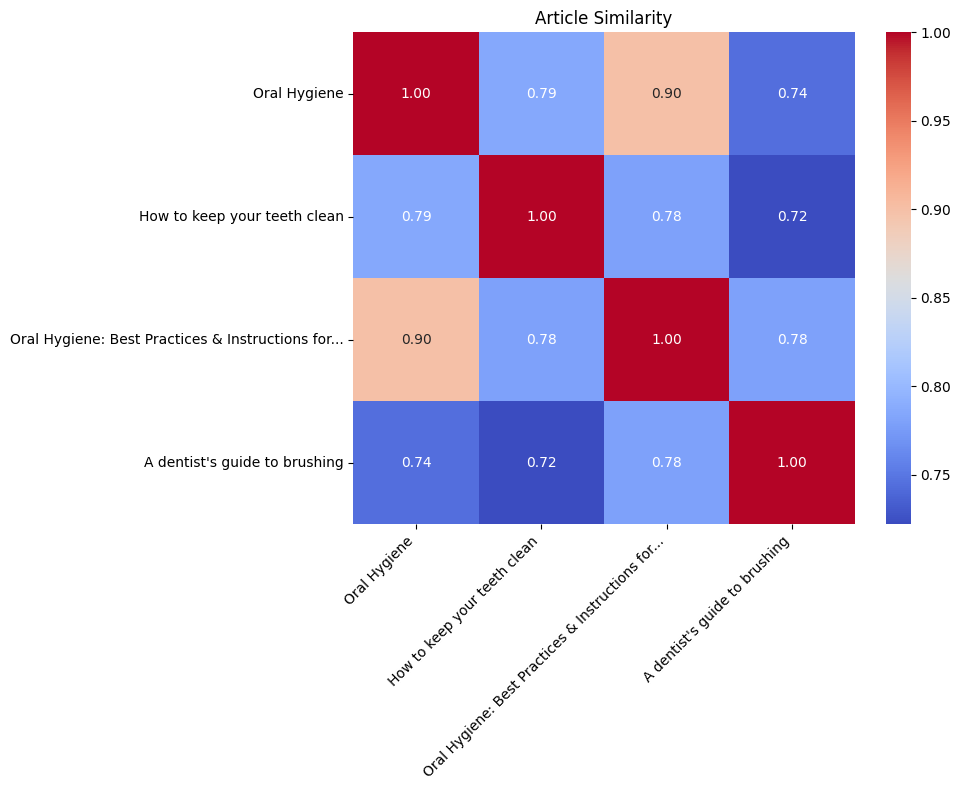

In [27]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=truncated_texts, yticklabels=truncated_texts)
plt.title("Article Similarity")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()